# Canada VAR Pipeline — Bayesian vs Frequentist Comparison

> **R → Python Conversion** of the Canada macroeconomic VAR forecasting pipeline.  
> Rolling 1-step-ahead forecasts on **levels** via differenced VAR(p), sweeping p = 1…12.

---

## R → Python Correspondence

| R Component                                                 | Python Equivalent                                     |
| ----------------------------------------------------------- | ----------------------------------------------------- |
| `data("Canada")` from `vars` pkg                            | `statsmodels.datasets.get_rdataset("Canada", "vars")` |
| `diff(Y_levels)`                                            | `np.diff(Y_levels, axis=0)`                           |
| `glmnet(alpha=0, lambda=0.1)`                               | `sklearn.linear_model.Ridge(alpha=0.1)` per equation  |
| `stan("var_normal.stan", iter=2000, warmup=1000, chains=4)` | Gibbs sampler, 1000 burn-in + 4000 draws              |
| `stan("var_lasso.stan", lambda=1.0)`                        | Gibbs sampler with InvGaussian scale mixture          |
| `stan("var_horseshoe.stan")`                                | Gibbs sampler with half-Cauchy auxiliary vars         |
| `one_step_ahead_forecast(B, ...)`                           | `run_rolling_forecast(B_hat, ...)`                    |
| `get_accuracy_metrics_by_series_and_overall(...)`           | `MetricsEngine.compute_all_metrics(...)`              |

---

## Extensibility

To add a **new model**, simply:

```python
class MyNewVAR(VARModel):
    def fit(self, X, Y, d, p): ...
    def get_coefficients(self): ...
    def get_intervals(self, alpha): ...

MODEL_REGISTRY["MyNew"] = lambda: MyNewVAR(params)
```

No changes to forecast engine, metrics, or experiment code needed.


## Section 1 — Setup & Configuration

All parameters match the R pipeline **exactly**:

- Ridge: `glmnet(alpha=0, lambda=0.1, intercept=FALSE, family="mgaussian")`
- Normal prior: `prior_scale = 1.0`
- Lasso prior: `lambda = 1.0`
- Stan: `iter=2000, warmup=1000, chains=4` → Python: `1000 burn-in + 4000 draws`
- Lag sweep: `p = 1 to 12`
- Test holdout: last 4 differences


In [1]:
# ============================================================
# Section 1 — Imports & Configuration
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pickle
import warnings
from abc import ABC, abstractmethod
from scipy.linalg import inv, cholesky
from scipy import stats
from sklearn.linear_model import Ridge
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings('ignore')

plt.rcParams.update({
    'figure.figsize': (14, 6),
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 120,
})

# ── R Pipeline Parameters (EXACT match) ─────────────────────
# R: glmnet(alpha=0, lambda=0.1, intercept=FALSE)
LAMBDA_RIDGE = 0.1

# R: stan_data_normal = list(prior_scale = 1.0)
NORMAL_PRIOR_SCALE = 1.0

# R: stan_data_lasso = list(lambda = 1.0)
LASSO_LAMBDA = 1.0

# R: Ttest_diff <- 4
T_TEST_DIFFS = 4

# R: for (pval in 1:12)
LAG_MIN = 1
LAG_MAX = 12

# ── MCMC Settings ────────────────────────────────────────────
# R: iter=2000, warmup=1000, chains=4 → total post-warmup = 4000
MCMC_BURNIN = 1000
TOTAL_DRAWS = 4000

# ── Bootstrap Settings (Ridge CIs) ──────────────────────────
N_BOOT = 50
BLOCK_SIZE = 4
CI_ALPHA = 0.05

# ── Reproducibility ─────────────────────────────────────────
SEED = 123

# ── Canada dataset column names ──────────────────────────────
COL_NAMES = ['e', 'prod', 'rw', 'U']
COL_LABELS = {
    'e': 'Employment',
    'prod': 'Labor Productivity',
    'rw': 'Real Wage',
    'U': 'Unemployment Rate',
}

# ── Output directory ─────────────────────────────────────────
OUTPUT_DIR = os.path.join(os.getcwd(), 'canada_var_results')
os.makedirs(OUTPUT_DIR, exist_ok=True)

print('Configuration loaded.')
print(f'  Lambda Ridge:     {LAMBDA_RIDGE}')
print(f'  Normal prior σ:   {NORMAL_PRIOR_SCALE}')
print(f'  Lasso λ:          {LASSO_LAMBDA}')
print(f'  Test holdout:     {T_TEST_DIFFS} diffs')
print(f'  Lag sweep:        p = {LAG_MIN}..{LAG_MAX}')
print(f'  MCMC draws:       {TOTAL_DRAWS} (burn-in {MCMC_BURNIN})')
print(f'  Output dir:       {OUTPUT_DIR}')
print('Environment ready. ✅')

Configuration loaded.
  Lambda Ridge:     0.1
  Normal prior σ:   1.0
  Lasso λ:          1.0
  Test holdout:     4 diffs
  Lag sweep:        p = 1..12
  MCMC draws:       4000 (burn-in 1000)
  Output dir:       d:\Bayesian Regresion\Lasso\canada_var_results
Environment ready. ✅


## Section 2 — Data Loading & Exploratory Data Analysis

The **Canada** dataset from R's `vars` package contains 84 quarterly observations (1980Q1–2000Q4)
of 4 Canadian macroeconomic series:

- **e** — Employment (log, ×100)
- **prod** — Labor productivity (log, ×100)
- **rw** — Real wage (log, ×100)
- **U** — Unemployment rate (%)

> EDA includes: raw series plots, differenced series plots, ACF/PACF, cross-correlation.
> **This section does NOT alter the modeling pipeline.**


In [3]:
# ============================================================
# Section 2.1 — Load Canada Dataset
# ============================================================
# R: data("Canada")   →  from the 'vars' CRAN package
# Primary: local CSV exported from R (84 rows × 4 cols)
# Fallback 1: statsmodels.datasets.get_rdataset
# Fallback 2: direct URL
# ============================================================

local_csv = os.path.join(os.getcwd(), 'canada_data.csv')

if os.path.exists(local_csv):
    df_canada = pd.read_csv(local_csv, index_col=0)
    print(f'Loaded Canada data from local CSV ✅  ({local_csv})')
else:
    try:
        from statsmodels.datasets import get_rdataset
        canada_ds = get_rdataset('Canada', 'vars')
        df_canada = canada_ds.data
        print('Loaded Canada data via statsmodels.datasets.get_rdataset ✅')
    except Exception as e:
        print(f'get_rdataset failed ({e}), trying direct URL...')
        url = 'https://vincentarelbundock.github.io/Rdatasets/csv/vars/Canada.csv'
        df_canada = pd.read_csv(url, index_col=0)
        print(f'Loaded Canada data from URL ✅')

# Standardise column names
df_canada.columns = [c.strip() for c in df_canada.columns]
if 'e' not in df_canada.columns:
    df_canada.columns = COL_NAMES[:df_canada.shape[1]]

# Extract levels matrix (matches R: Y_levels <- as.matrix(Canada[,1:4]))
Y_levels = df_canada[COL_NAMES].values.astype(np.float64)
Tfull = Y_levels.shape[0]
d = Y_levels.shape[1]

print(f'\nCanada dataset:')
print(f'  Shape:      {Y_levels.shape} ({Tfull} quarters × {d} variables)')
print(f'  Variables:  {COL_NAMES}')
print(f'  Period:     1980-Q1 to 2000-Q4 ({Tfull} quarters)')
print(f'\nFirst 5 rows:')
print(df_canada[COL_NAMES].head())
print(f'\nDescriptive statistics:')
print(df_canada[COL_NAMES].describe().round(3))

Loaded Canada data from local CSV ✅  (d:\Bayesian Regresion\Lasso\canada_data.csv)

Canada dataset:
  Shape:      (84, 4) (84 quarters × 4 variables)
  Variables:  ['e', 'prod', 'rw', 'U']
  Period:     1980-Q1 to 2000-Q4 (84 quarters)

First 5 rows:
            e        prod          rw     U
1  929.610514  405.366466  386.136109  7.53
2  929.803985  404.639834  388.135759  7.70
3  930.318388  403.814883  390.540113  7.47
4  931.427687  404.215773  393.963817  7.27
5  932.662006  405.046714  396.764691  7.37

Descriptive statistics:
             e     prod       rw       U
count   84.000   84.000   84.000  84.000
mean   944.257  407.821  440.751   9.321
std      9.158    4.216   23.270   1.607
min    928.563  401.307  386.136   6.700
25%    935.353  404.750  423.898   7.783
50%    945.952  406.458  444.441   9.450
75%    950.028  410.700  461.095  10.608
max    961.766  418.003  470.012  12.770


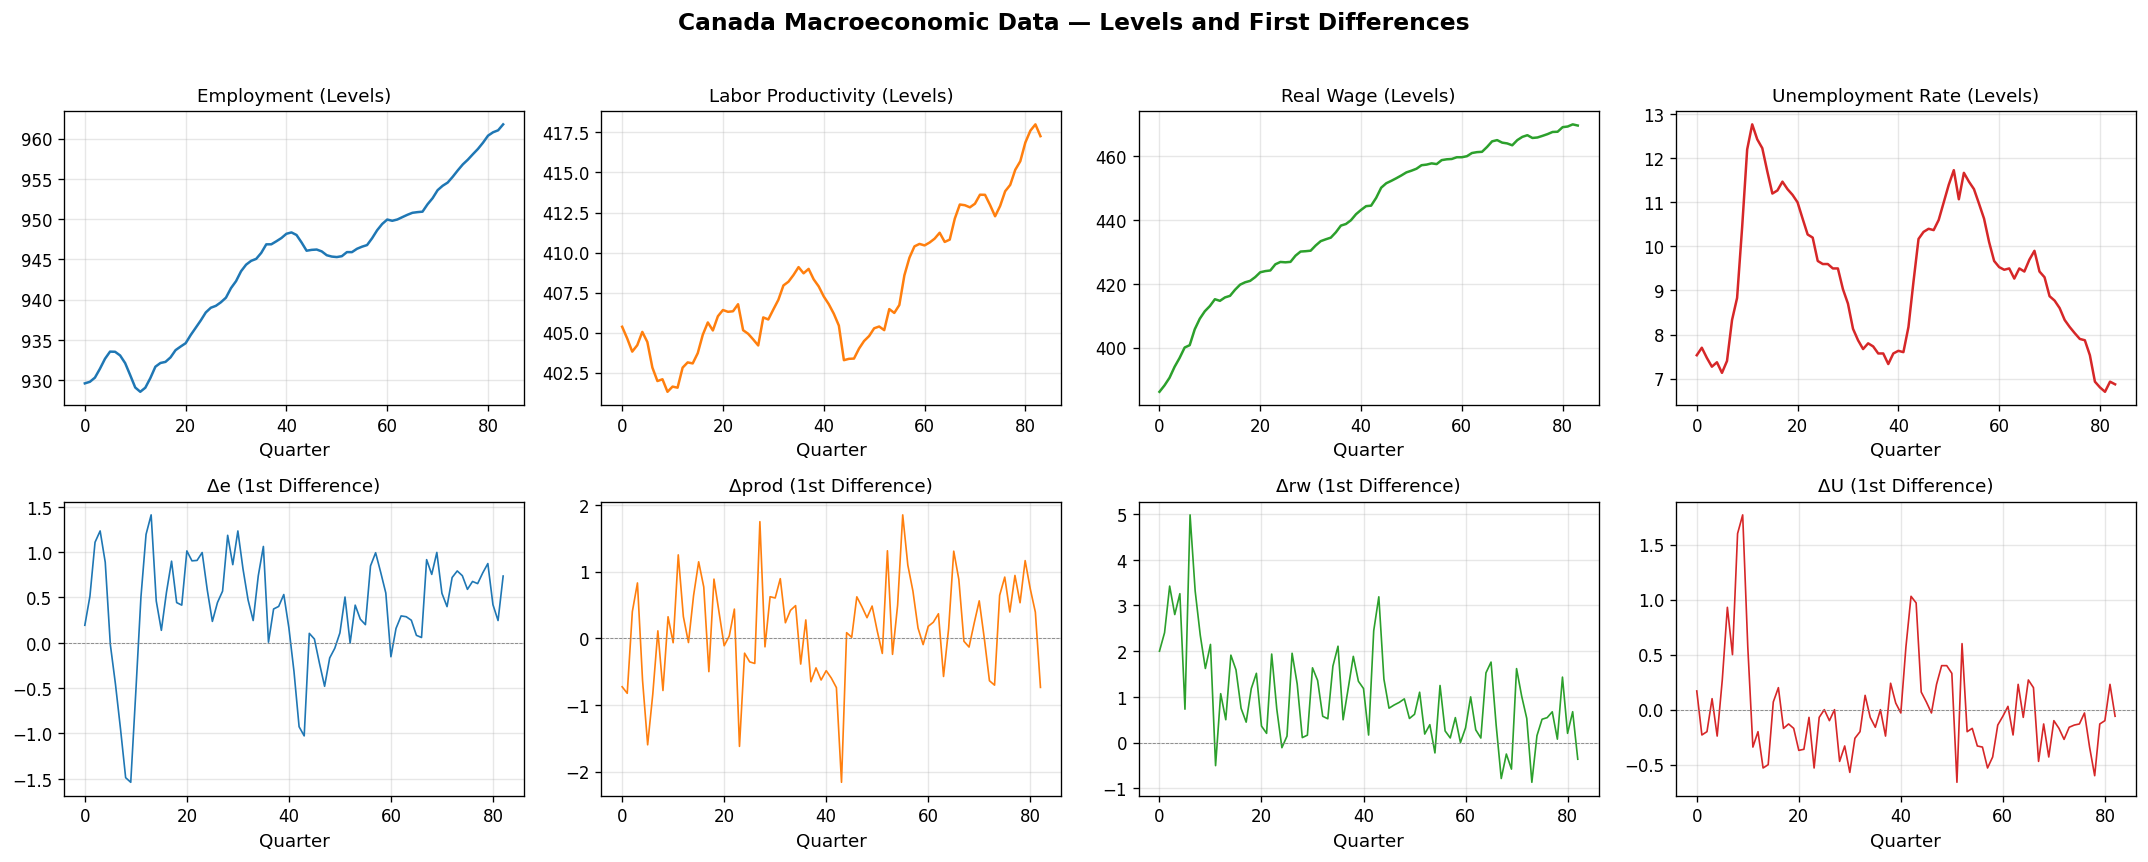

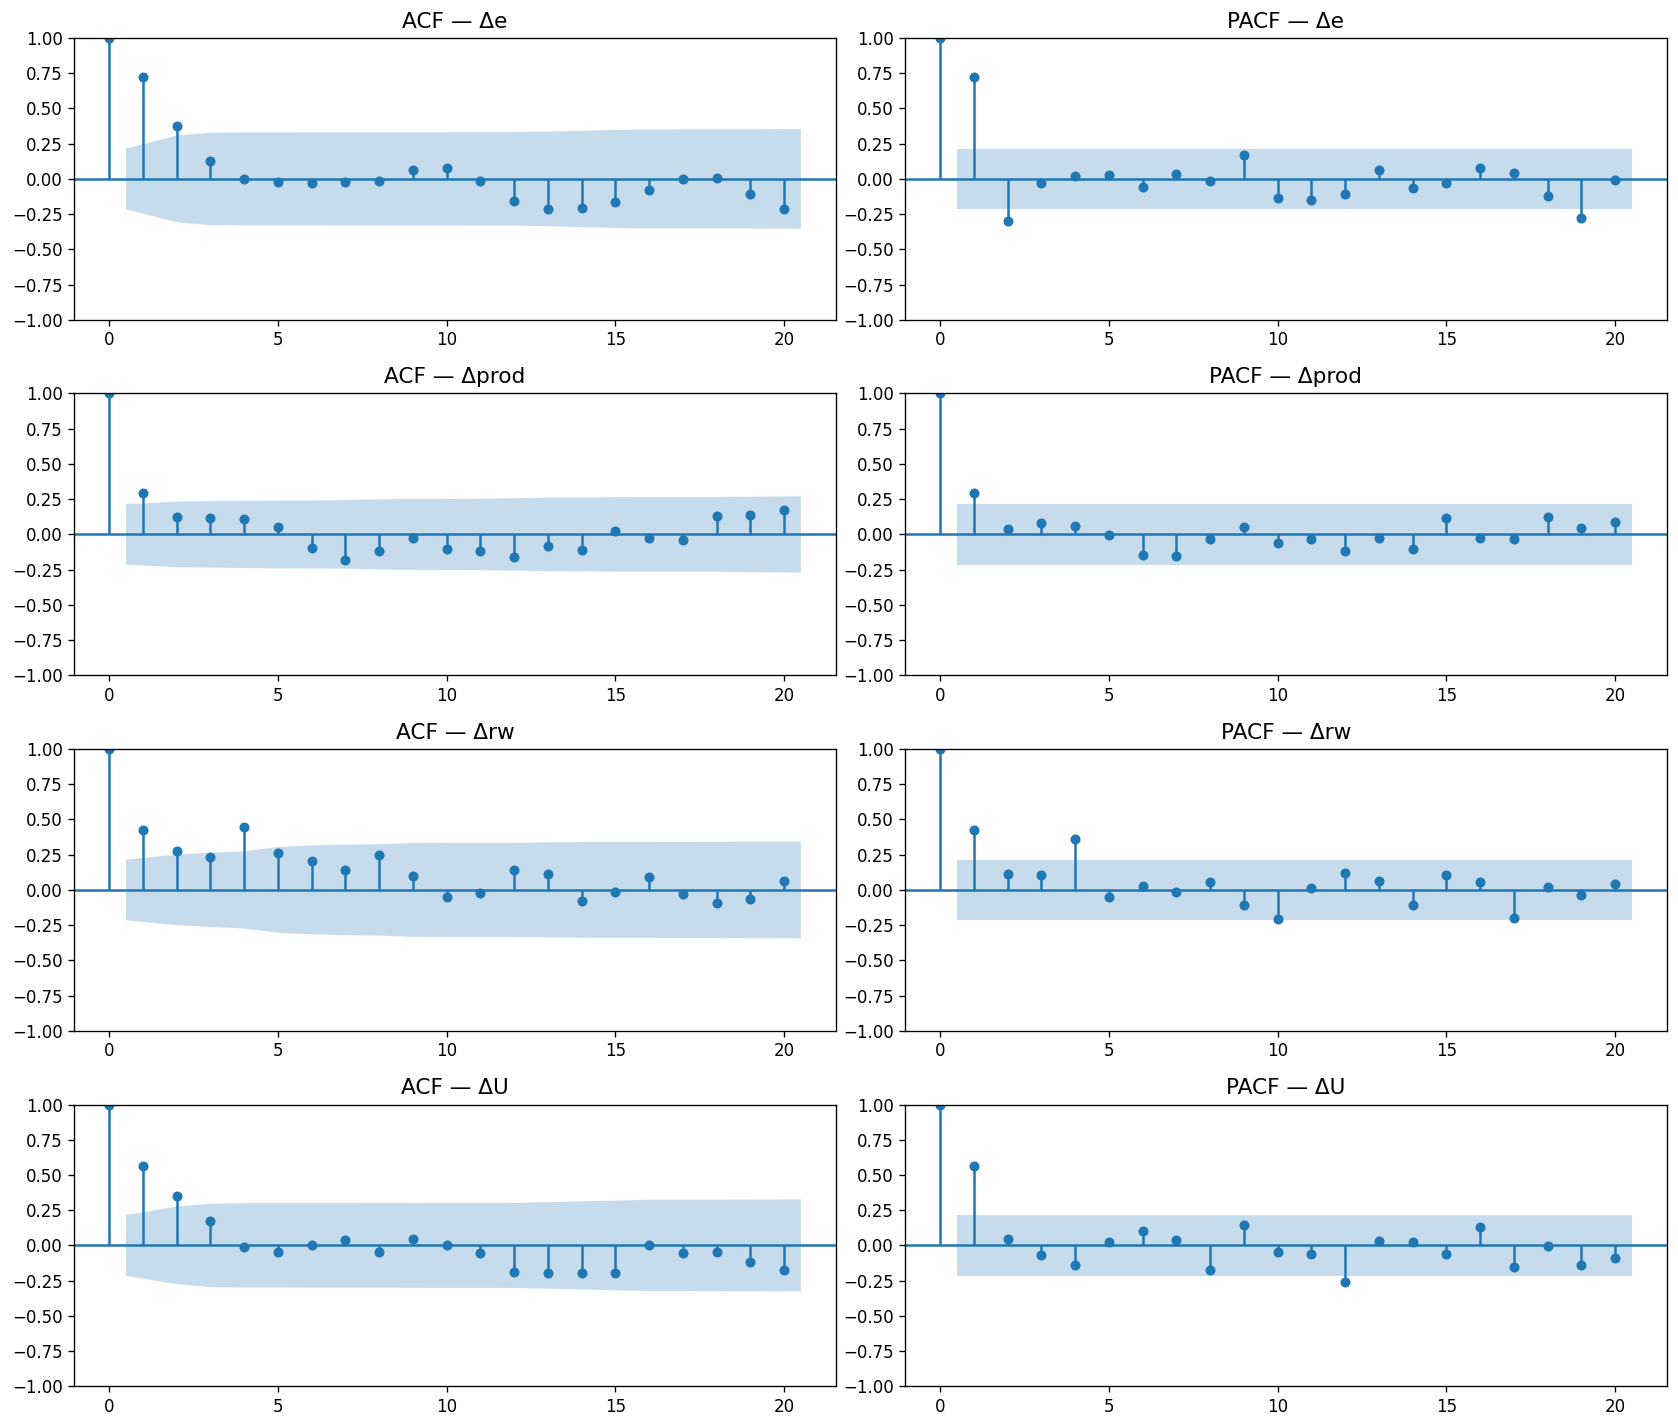

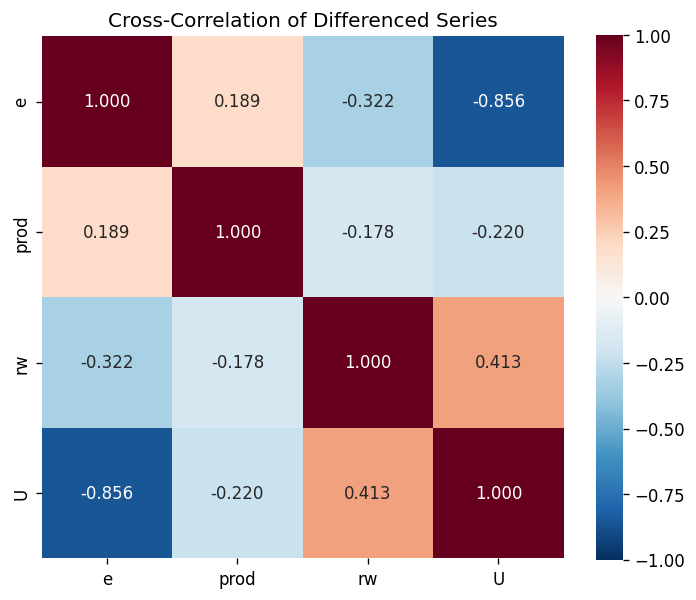

EDA complete. ✅


In [4]:
# ============================================================
# Section 2.2 — EDA: Raw Series, Differenced Series, ACF/PACF
# ============================================================

Y_diff_full = np.diff(Y_levels, axis=0)

# ── Panel 1: Raw Levels & First Differences (2 × 4 grid) ────
fig, axes = plt.subplots(2, 4, figsize=(18, 7))

for j, col in enumerate(COL_NAMES):
    # Row 1: Levels
    ax = axes[0, j]
    ax.plot(Y_levels[:, j], color=f'C{j}', linewidth=1.5)
    ax.set_title(f'{COL_LABELS[col]} (Levels)', fontsize=11)
    ax.set_xlabel('Quarter')
    ax.grid(alpha=0.3)
    
    # Row 2: Differences
    ax = axes[1, j]
    ax.plot(Y_diff_full[:, j], color=f'C{j}', linewidth=1)
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    ax.set_title(f'Δ{col} (1st Difference)', fontsize=11)
    ax.set_xlabel('Quarter')
    ax.grid(alpha=0.3)

fig.suptitle('Canada Macroeconomic Data — Levels and First Differences',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ── Panel 2: ACF / PACF for differenced series (4 × 2 grid) ─
fig, axes = plt.subplots(4, 2, figsize=(14, 12))

for j, col in enumerate(COL_NAMES):
    plot_acf(Y_diff_full[:, j], ax=axes[j, 0], lags=20,
             title=f'ACF — Δ{col}')
    plot_pacf(Y_diff_full[:, j], ax=axes[j, 1], lags=20,
              method='ywm', title=f'PACF — Δ{col}')

plt.tight_layout()
plt.show()

# ── Panel 3: Cross-Correlation Heatmap ───────────────────────
df_diff = pd.DataFrame(Y_diff_full, columns=COL_NAMES)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(df_diff.corr(), annot=True, fmt='.3f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, ax=ax, square=True)
ax.set_title('Cross-Correlation of Differenced Series', fontsize=12)
plt.tight_layout()
plt.show()

print('EDA complete. ✅')

## Section 3 — Preprocessing (Differencing) + Section 4 — VAR Design Matrix

**Differencing**: `Y_diff = diff(Y_levels)` — exact R match.  
**Train/Test Split**: Last 4 differences held out for testing.  
**Design Matrix**: `make_var_design_p(Y, p)` matches R `make_VAR_design_p` exactly:

```
for lag_i in 1:p:
    lag_vec <- c(lag_vec, Y[t - lag_i, ])
```

Ordering: `[y_{t-1}, y_{t-2}, ..., y_{t-p}]` where each `y_{t-k}` is a d-vector.


In [5]:
# ============================================================
# Section 3 — Differencing + Train/Test Split
# ============================================================
# R: Y_diff <- diff(Y_levels)
#    Ttrain_diff <- Tfull_diff - 4
#    Ytrain_diff <- Y_diff[1:Ttrain_diff, ]
#    Ytest_diff  <- Y_diff[(Ttrain_diff+1):Tfull_diff, ]
#    Ytrain_levels <- Y_levels[1:(Ttrain_diff+1), ]
#    Ytest_levels  <- Y_levels[(Ttrain_diff+1):Tfull_levels, ]
# ============================================================

Y_diff = np.diff(Y_levels, axis=0)
Tfull_levels = Y_levels.shape[0]
Tfull_diff = Y_diff.shape[0]
d = Y_diff.shape[1]

Ttrain_diff = Tfull_diff - T_TEST_DIFFS
Ytrain_diff = Y_diff[:Ttrain_diff]
Ytest_diff  = Y_diff[Ttrain_diff:]

# Corresponding levels split
# R: Ytrain_levels has Ttrain_diff + 1 rows (last row = init for test)
# R: Ytest_levels has T_TEST_DIFFS + 1 rows (first row = shared with train end)
Ytrain_levels = Y_levels[:Ttrain_diff + 1]
Ytest_levels  = Y_levels[Ttrain_diff:]

# Actual test levels: rows 2..end of Ytest_levels
# R: actual_test_vals <- Ytest_levels[2:(Ttest_diff+1), ]
actual_test_levels = Ytest_levels[1:]

print('Differencing + Train/Test Split:')
print(f'  Y_diff shape:          {Y_diff.shape}')
print(f'  Ytrain_diff shape:     {Ytrain_diff.shape}')
print(f'  Ytest_diff shape:      {Ytest_diff.shape}')
print(f'  Ytrain_levels shape:   {Ytrain_levels.shape}')
print(f'  Ytest_levels shape:    {Ytest_levels.shape}')
print(f'  actual_test_levels:    {actual_test_levels.shape}')
print(f'  d (variables):         {d}')

# ============================================================
# Section 4 — VAR(p) Design Matrix Builder
# ============================================================
# Matches R: make_VAR_design_p(Y, p) EXACTLY
#   for (t in (p+1):T) {
#     for (lag_i in 1:p) {
#       lag_vec <- c(lag_vec, Y[t - lag_i, ])
#     }
#     X[row_idx, ] <- lag_vec
#   }
# ============================================================

def make_var_design_p(Y, p):
    """Build VAR(p) design matrix from differenced data.
    
    Matches R make_VAR_design_p EXACTLY.
    
    Parameters
    ----------
    Y : ndarray (T, d) — differenced data
    p : int — lag order
    
    Returns
    -------
    X : ndarray (T-p, d*p) — design matrix
    Y_out : ndarray (T-p, d) — response matrix
    """
    T, d = Y.shape
    if T - p <= 0:
        return None, None
    
    X = np.zeros((T - p, d * p))
    Y_out = Y[p:]
    
    for t in range(p, T):
        row_idx = t - p
        lag_vec = []
        for lag_i in range(1, p + 1):
            lag_vec.extend(Y[t - lag_i].tolist())
        X[row_idx] = lag_vec
    
    return X, Y_out


# Sanity check
X_test, Y_test = make_var_design_p(Ytrain_diff, 2)
print(f'\nDesign matrix sanity check (p=2):')
print(f'  X shape: {X_test.shape}  (expected: ({Ttrain_diff - 2}, {d * 2}))')
print(f'  Y shape: {Y_test.shape}  (expected: ({Ttrain_diff - 2}, {d}))')
print('Preprocessing + Design Matrix defined. ✅')

Differencing + Train/Test Split:
  Y_diff shape:          (83, 4)
  Ytrain_diff shape:     (79, 4)
  Ytest_diff shape:      (4, 4)
  Ytrain_levels shape:   (80, 4)
  Ytest_levels shape:    (5, 4)
  actual_test_levels:    (4, 4)
  d (variables):         4

Design matrix sanity check (p=2):
  X shape: (77, 8)  (expected: (77, 8))
  Y shape: (77, 4)  (expected: (77, 4))
Preprocessing + Design Matrix defined. ✅


## Section 5 — Model Interface & Implementations

### Extensible Architecture

All models implement the `VARModel` abstract base class:

| Method                    | Interface                         | Status       |
| ------------------------- | --------------------------------- | ------------ |
| `fit(X, Y, d, p)`         | Train model on design matrix      | **Required** |
| `get_coefficients()`      | Return B̂ matrix (d × d·p)         | **Required** |
| `get_intervals(α)`        | Return (B_lower, B_upper)         | **Required** |
| `predict(X)`              | Y_pred = X @ B̂ᵀ                   | Inherited    |
| `get_posterior_samples()` | Return MCMC draws (Bayesian only) | Optional     |

### Models (REUSED from `var_simulation_pipeline.ipynb`)

All 4 model classes are **reused verbatim** from the simulation pipeline.
The Gibbs sampler logic, priors, and posterior conditionals are **identical**.
Only the default hyperparameters are set to match the Canada R pipeline.


In [6]:
# ============================================================
# Section 5.1 — VARModel Abstract Base Class
# ============================================================
# [REUSED] from var_simulation_pipeline.ipynb — IDENTICAL
# ============================================================

class VARModel(ABC):
    """Abstract base class for all VAR estimation methods.
    
    Any new model must implement these methods to plug into
    the experiment runner without changes.
    """
    
    @property
    @abstractmethod
    def name(self) -> str:
        """Human-readable model name."""
        ...
    
    @property
    def is_bayesian(self) -> bool:
        """Whether this model produces posterior samples."""
        return False
    
    @abstractmethod
    def fit(self, X_train, Y_train, d, p_fit):
        """Fit the VAR model.
        
        Parameters
        ----------
        X_train : ndarray (n_train, d*p_fit)
        Y_train : ndarray (n_train, d)
        d : int — number of variables
        p_fit : int — number of lags
        """
        ...
    
    @abstractmethod
    def get_coefficients(self):
        """Return point estimate of B matrix, shape (d, d*p_fit)."""
        ...
    
    @abstractmethod
    def get_intervals(self, alpha=0.05):
        """Return (B_lower, B_upper), each shape (d, d*p_fit)."""
        ...
    
    def predict(self, X_test):
        """1-step-ahead prediction: Y_pred = X_test @ B.T"""
        B = self.get_coefficients()
        return X_test @ B.T
    
    def get_posterior_samples(self):
        """Return posterior samples of B. None for non-Bayesian."""
        return None


# ============================================================
# Section 5.2 — Shared Sampling Utilities
# ============================================================
# [REUSED] from var_simulation_pipeline.ipynb — IDENTICAL
# ============================================================

def sample_inv_gamma(shape, scale, rng=np.random):
    """Sample from Inverse-Gamma(shape, scale).
    [REUSED] from unified_comparison.ipynb"""
    return 1.0 / rng.gamma(shape, 1.0 / scale)


def hpd_interval(samples, alpha=0.05):
    """Compute Highest Posterior Density interval.
    [REUSED] from unified_comparison.ipynb"""
    x = np.sort(samples)
    n = len(x)
    k = int(np.floor((1.0 - alpha) * n))
    if k == 0:
        return x[0], x[-1]
    widths = x[k:] - x[:n - k]
    best = np.argmin(widths)
    return x[best], x[best + k]


def safe_cholesky(M, max_jitter=1e-4):
    """Cholesky with progressive jitter for numerical stability.
    [REUSED] from unified_comparison.ipynb"""
    jitter = 1e-10
    I = np.eye(M.shape[0])
    while jitter <= max_jitter:
        try:
            return cholesky(M + jitter * I, lower=True)
        except np.linalg.LinAlgError:
            jitter *= 10
    return cholesky(M + max_jitter * I, lower=True)


print('VARModel ABC + shared utilities defined. ✅')

VARModel ABC + shared utilities defined. ✅


In [7]:
# ============================================================
# Section 5.3 — Ridge VAR (Frequentist)
# ============================================================
# [REUSED] from var_simulation_pipeline.ipynb — IDENTICAL sampler
# R: glmnet(alpha=0, lambda=0.1, intercept=FALSE, family="mgaussian")
# ============================================================

class RidgeVAR(VARModel):
    """Frequentist Ridge VAR — sklearn Ridge per equation + block bootstrap CIs.
    [REUSED] from var_simulation_pipeline.ipynb"""
    
    def __init__(self, lambda_ridge=LAMBDA_RIDGE, n_boot=N_BOOT,
                 block_size=BLOCK_SIZE, alpha=CI_ALPHA):
        self.lambda_ridge = lambda_ridge
        self.n_boot = n_boot
        self.block_size = block_size
        self.alpha = alpha
        self._name = 'Ridge'
    
    @property
    def name(self):
        return self._name
    
    def fit(self, X_train, Y_train, d, p_fit):
        self.d_ = d
        self.p_fit_ = p_fit
        n = X_train.shape[0]
        
        self.B_hat_ = np.zeros((d, d * p_fit))
        for j in range(d):
            model = Ridge(alpha=self.lambda_ridge, fit_intercept=False)
            model.fit(X_train, Y_train[:, j])
            self.B_hat_[j, :] = model.coef_
        
        # Block bootstrap for standard errors
        B_boot = np.zeros((self.n_boot, d, d * p_fit))
        for b in range(self.n_boot):
            idx = self._sample_ts_blocks(n)
            Xb, Yb = X_train[idx], Y_train[idx]
            for j in range(d):
                m = Ridge(alpha=self.lambda_ridge, fit_intercept=False)
                m.fit(Xb, Yb[:, j])
                B_boot[b, j, :] = m.coef_
        
        self.B_sd_ = np.std(B_boot, axis=0)
        z = stats.norm.ppf(1 - self.alpha / 2)
        self.B_lower_ = self.B_hat_ - z * self.B_sd_
        self.B_upper_ = self.B_hat_ + z * self.B_sd_
        return self
    
    def _sample_ts_blocks(self, n):
        """Block bootstrap indices — matches R sample_ts_blocks."""
        nblocks = int(np.ceil(n / self.block_size))
        starts = np.random.randint(0, n - self.block_size + 1, size=nblocks)
        idx = []
        for s in starts:
            idx.extend(range(s, s + self.block_size))
        return idx[:n]
    
    def get_coefficients(self):
        return self.B_hat_
    
    def get_intervals(self, alpha=0.05):
        if alpha != self.alpha:
            z = stats.norm.ppf(1 - alpha / 2)
            return self.B_hat_ - z * self.B_sd_, self.B_hat_ + z * self.B_sd_
        return self.B_lower_, self.B_upper_


print('RidgeVAR class defined. ✅')

RidgeVAR class defined. ✅


In [8]:
# ============================================================
# Section 5.4 — Bayesian Normal Prior VAR
# ============================================================
# [REUSED] from var_simulation_pipeline.ipynb — IDENTICAL Gibbs
# R: stan("var_normal.stan", prior_scale=1.0)
# ============================================================

class BayesianNormalVAR(VARModel):
    """Bayesian VAR with Normal prior. Per-equation Gibbs sampler.
    [REUSED] from var_simulation_pipeline.ipynb — same full conditionals."""
    
    def __init__(self, prior_scale=NORMAL_PRIOR_SCALE, n_iter=None,
                 burn_in=MCMC_BURNIN, seed_offset=0):
        self.prior_scale = prior_scale
        self.n_iter = n_iter or (MCMC_BURNIN + TOTAL_DRAWS)
        self.burn_in = burn_in
        self.seed_offset = seed_offset
        self._name = 'Normal'
    
    @property
    def name(self):
        return self._name
    
    @property
    def is_bayesian(self):
        return True
    
    def fit(self, X_train, Y_train, d, p_fit):
        self.d_ = d
        self.p_fit_ = p_fit
        n, q = X_train.shape
        rng = np.random.RandomState(SEED + self.seed_offset)
        
        XtX = X_train.T @ X_train
        prior_prec = (1.0 / self.prior_scale**2) * np.eye(q)
        A = XtX + prior_prec
        A_inv = inv(A)
        
        B_samples = np.zeros((self.n_iter - self.burn_in, d, q))
        sigma2 = np.ones(d) * 0.1
        B = np.zeros((d, q))
        
        for it in range(self.n_iter):
            for j in range(d):
                Xty_j = X_train.T @ Y_train[:, j]
                mu_j = A_inv @ Xty_j
                L = safe_cholesky(sigma2[j] * A_inv)
                B[j, :] = mu_j + L @ rng.randn(q)
                
                resid_j = Y_train[:, j] - X_train @ B[j, :]
                shape_s = (n + q) / 2
                scale_s = (resid_j @ resid_j +
                           B[j, :] @ prior_prec @ B[j, :]) / 2
                sigma2[j] = sample_inv_gamma(shape_s, scale_s, rng)
            
            if it >= self.burn_in:
                B_samples[it - self.burn_in] = B.copy()
        
        self.B_samples_ = B_samples
        self.B_hat_ = np.mean(B_samples, axis=0)
        self.B_lower_ = np.percentile(B_samples, 2.5, axis=0)
        self.B_upper_ = np.percentile(B_samples, 97.5, axis=0)
        return self
    
    def get_coefficients(self):
        return self.B_hat_
    
    def get_intervals(self, alpha=0.05):
        lo = np.percentile(self.B_samples_, 100 * alpha / 2, axis=0)
        hi = np.percentile(self.B_samples_, 100 * (1 - alpha / 2), axis=0)
        return lo, hi
    
    def get_posterior_samples(self):
        return self.B_samples_


# ============================================================
# Section 5.5 — Bayesian Lasso VAR
# ============================================================
# [REUSED] from var_simulation_pipeline.ipynb — IDENTICAL Gibbs
# R: stan("var_lasso.stan", lambda=1.0)
# ============================================================

class BayesianLassoVAR(VARModel):
    """Bayesian VAR with Laplace prior via InvGaussian scale mixture.
    [REUSED] from var_simulation_pipeline.ipynb — same full conditionals."""
    
    def __init__(self, lasso_lambda=LASSO_LAMBDA, n_iter=None,
                 burn_in=MCMC_BURNIN, seed_offset=0):
        self.lasso_lambda = lasso_lambda
        self.n_iter = n_iter or (MCMC_BURNIN + TOTAL_DRAWS)
        self.burn_in = burn_in
        self.seed_offset = seed_offset
        self._name = 'Lasso'
    
    @property
    def name(self):
        return self._name
    
    @property
    def is_bayesian(self):
        return True
    
    def fit(self, X_train, Y_train, d, p_fit):
        self.d_ = d
        self.p_fit_ = p_fit
        n, q = X_train.shape
        rng = np.random.RandomState(SEED + self.seed_offset)
        lam = self.lasso_lambda
        
        XtX = X_train.T @ X_train
        B = np.zeros((d, q))
        sigma2 = np.ones(d) * 0.1
        tau2 = np.ones((d, q))
        
        B_samples = np.zeros((self.n_iter - self.burn_in, d, q))
        
        for it in range(self.n_iter):
            for j in range(d):
                D_tau_inv = np.diag(1.0 / tau2[j, :])
                A = XtX + D_tau_inv
                A_inv = inv(A)
                Xty_j = X_train.T @ Y_train[:, j]
                mu_j = A_inv @ Xty_j
                L = safe_cholesky(sigma2[j] * A_inv)
                B[j, :] = mu_j + L @ rng.randn(q)
                
                resid_j = Y_train[:, j] - X_train @ B[j, :]
                shape_s = (n - 1 + q) / 2
                scale_s = (resid_j @ resid_j +
                           B[j, :] @ D_tau_inv @ B[j, :]) / 2
                sigma2[j] = sample_inv_gamma(shape_s, scale_s, rng)
                
                for k in range(q):
                    mu_ig = np.sqrt(lam**2 * sigma2[j] /
                                    (B[j, k]**2 + 1e-12))
                    tau2[j, k] = 1.0 / rng.wald(mu_ig, lam**2)
            
            if it >= self.burn_in:
                B_samples[it - self.burn_in] = B.copy()
        
        self.B_samples_ = B_samples
        self.B_hat_ = np.mean(B_samples, axis=0)
        self.B_lower_ = np.percentile(B_samples, 2.5, axis=0)
        self.B_upper_ = np.percentile(B_samples, 97.5, axis=0)
        return self
    
    def get_coefficients(self):
        return self.B_hat_
    
    def get_intervals(self, alpha=0.05):
        lo = np.percentile(self.B_samples_, 100 * alpha / 2, axis=0)
        hi = np.percentile(self.B_samples_, 100 * (1 - alpha / 2), axis=0)
        return lo, hi
    
    def get_posterior_samples(self):
        return self.B_samples_


# ============================================================
# Section 5.6 — Horseshoe VAR
# ============================================================
# [REUSED] from var_simulation_pipeline.ipynb — IDENTICAL Gibbs
# R: stan("var_horseshoe.stan")
# ============================================================

class HorseshoeVAR(VARModel):
    """Bayesian VAR with Horseshoe (global-local half-Cauchy) prior.
    [REUSED] from var_simulation_pipeline.ipynb — same auxiliary variable scheme."""
    
    def __init__(self, n_iter=None, burn_in=MCMC_BURNIN, seed_offset=0):
        self.n_iter = n_iter or (MCMC_BURNIN + TOTAL_DRAWS)
        self.burn_in = burn_in
        self.seed_offset = seed_offset
        self._name = 'Horseshoe'
    
    @property
    def name(self):
        return self._name
    
    @property
    def is_bayesian(self):
        return True
    
    def fit(self, X_train, Y_train, d, p_fit):
        self.d_ = d
        self.p_fit_ = p_fit
        n, q = X_train.shape
        rng = np.random.RandomState(SEED + self.seed_offset)
        
        XtX = X_train.T @ X_train
        B = np.zeros((d, q))
        sigma2 = np.ones(d) * 0.1
        lambda2 = np.ones((d, q))
        nu = np.ones((d, q))
        tau2 = np.ones(d)
        xi = np.ones(d)
        
        B_samples = np.zeros((self.n_iter - self.burn_in, d, q))
        
        for it in range(self.n_iter):
            for j in range(d):
                D_inv = np.diag(1.0 / (tau2[j] * lambda2[j, :]))
                Sigma_B = inv(XtX + D_inv)
                Xty_j = X_train.T @ Y_train[:, j]
                mu_j = Sigma_B @ Xty_j
                L = safe_cholesky(sigma2[j] * Sigma_B)
                B[j, :] = mu_j + L @ rng.randn(q)
                
                resid_j = Y_train[:, j] - X_train @ B[j, :]
                shape_s = (n + q) / 2
                scale_s = (resid_j @ resid_j +
                           B[j, :] @ D_inv @ B[j, :]) / 2
                sigma2[j] = sample_inv_gamma(shape_s, scale_s, rng)
                
                for k in range(q):
                    shape_lk = 1.0
                    scale_lk = (1.0 / nu[j, k] +
                                B[j, k]**2 / (2 * sigma2[j] * tau2[j]))
                    lambda2[j, k] = sample_inv_gamma(shape_lk, scale_lk, rng)
                
                for k in range(q):
                    nu[j, k] = sample_inv_gamma(
                        1.0, 1.0 + 1.0 / lambda2[j, k], rng)
                
                shape_t = (q + 1) / 2
                scale_t = (1.0 / xi[j] +
                           np.sum(B[j, :]**2 / lambda2[j, :]) /
                           (2 * sigma2[j]))
                tau2[j] = sample_inv_gamma(shape_t, scale_t, rng)
                xi[j] = sample_inv_gamma(1.0, 1.0 + 1.0 / tau2[j], rng)
            
            if it >= self.burn_in:
                B_samples[it - self.burn_in] = B.copy()
        
        self.B_samples_ = B_samples
        self.B_hat_ = np.mean(B_samples, axis=0)
        self.B_lower_ = np.percentile(B_samples, 2.5, axis=0)
        self.B_upper_ = np.percentile(B_samples, 97.5, axis=0)
        return self
    
    def get_coefficients(self):
        return self.B_hat_
    
    def get_intervals(self, alpha=0.05):
        lo = np.percentile(self.B_samples_, 100 * alpha / 2, axis=0)
        hi = np.percentile(self.B_samples_, 100 * (1 - alpha / 2), axis=0)
        return lo, hi
    
    def get_posterior_samples(self):
        return self.B_samples_


# ============================================================
# Section 5.7 — Model Registry (Extensible)
# ============================================================

MODEL_REGISTRY = {
    'Ridge':     lambda: RidgeVAR(),
    'Normal':    lambda: BayesianNormalVAR(),
    'Lasso':     lambda: BayesianLassoVAR(),
    'Horseshoe': lambda: HorseshoeVAR(),
}

print(f'Model registry: {list(MODEL_REGISTRY.keys())}')
print('To add a new model:')
print('  MODEL_REGISTRY["NewModel"] = lambda: NewModelClass(params)')
print('All 4 model classes + registry defined. ✅')

Model registry: ['Ridge', 'Normal', 'Lasso', 'Horseshoe']
To add a new model:
  MODEL_REGISTRY["NewModel"] = lambda: NewModelClass(params)
All 4 model classes + registry defined. ✅


## Section 6 — Rolling 1-Step-Ahead Forecast Engine

**R Reference:** `one_step_ahead_forecast()` in all 4 Canada scripts  
**Logic — matches R EXACTLY:**

1. Buffer `diff_history` ← last _p_ actual diffs from training
2. `current_level` ← last training level
3. For each test step _i_ = 1 … _T_\_test:
   - Build lag vector: `lag_vec = flatten(diff_history[p:1])` (most recent first)
   - Predict diff: `pred_diff = lag_vec @ B.T`
   - Forecast level: `pred_level = current_level + pred_diff`
   - **Update with actual**: `current_level ← Ytest_levels[i+1]`, `diff_history ← rbind(history[-1,], actual_diff)`

---

## Section 7 — Metrics Engine

**R Reference:** `get_accuracy_metrics_by_series()` + `get_accuracy_metrics_overall()`

- **RMSE** per series _j_: $\sqrt{\frac{1}{T}\sum_t (y_{t,j} - \hat{y}_{t,j})^2}$
- **MAPE** per series _j_: $\frac{100}{T}\sum_t \left|\frac{y_{t,j} - \hat{y}_{t,j}}{y_{t,j}}\right|$ (non-zero entries only, threshold `|y| > 1e-8`)
- **Overall**: Flatten all series, compute RMSE/MAPE across all $T \times d$ entries


In [9]:
# ============================================================
# Section 6 — Rolling 1-Step-Ahead Forecast Engine
# ============================================================
# Matches R: one_step_ahead_forecast() EXACTLY across all 4 scripts.
# REUSABLE: Takes any B_hat matrix → produces level forecasts.
# New models only need get_coefficients() → B_hat.
# ============================================================

def run_rolling_forecast(B_hat, Ytrain_diff, Ytrain_levels, Ytest_levels, p):
    """Rolling 1-step-ahead forecast on levels via differenced VAR(p).
    
    Matches R one_step_ahead_forecast() EXACTLY:
      lag_vec <- as.vector(t(diff_history[p:1, , drop=FALSE]))
      pred_diff <- lag_vec %*% t(B)
      pred_level <- current_level + pred_diff
      (update with actual next level)
    
    Parameters
    ----------
    B_hat        : ndarray (d, d*p) — fitted coefficient matrix
    Ytrain_diff  : ndarray (Ttrain, d) — training differences
    Ytrain_levels: ndarray (Ttrain+1, d) — training levels
    Ytest_levels : ndarray (Ttest+1, d) — test levels (row 0 = initial condition)
    p            : int — lag order
    
    Returns
    -------
    preds : ndarray (Ttest, d) — predicted levels for each test step
    """
    d = Ytrain_diff.shape[1]
    Ttest = Ytest_levels.shape[0] - 1
    preds = np.zeros((Ttest, d))
    
    # R: diff_history <- tail(Ytrain_diff, p)
    diff_history = Ytrain_diff[-p:].copy()  # (p, d)
    
    # R: current_level <- tail(Ytrain_levels, 1)
    current_level = Ytrain_levels[-1:].copy()  # (1, d)
    
    for i in range(Ttest):
        # (1) Build lag vector — most recent diff first
        # R: lag_vec <- as.vector(t(diff_history[p:1, , drop=FALSE]))
        lag_vec = diff_history[::-1].flatten().reshape(1, -1)  # (1, d*p)
        
        # (2) Predict next diff
        # R: pred_diff <- lag_vec %*% t(B)
        pred_diff = lag_vec @ B_hat.T  # (1, d)
        
        # (3) Forecast level
        # R: pred_level <- current_level + pred_diff
        pred_level = current_level + pred_diff
        preds[i] = pred_level
        
        # (4) Update with actual test values
        # R: actual_next_level <- Ytest_levels[i+1, ]
        actual_next = Ytest_levels[i + 1:i + 2]  # (1, d)
        new_diff = actual_next - current_level     # (1, d)
        
        # R: diff_history <- rbind(diff_history[-1,], new_diff)
        if p > 1:
            diff_history = np.vstack([diff_history[1:], new_diff])
        else:
            diff_history = new_diff.copy()
        
        current_level = actual_next.copy()
    
    return preds


# ============================================================
# Section 7 — Metrics Engine
# ============================================================
# Matches R: get_accuracy_metrics_by_series() +
#            get_accuracy_metrics_overall() EXACTLY.
# REUSABLE: Any (actual, predicted) pair → per-series + overall.
# ============================================================

class MetricsEngine:
    """Per-series and overall RMSE/MAPE — matching R exactly."""
    
    @staticmethod
    def rmse(actual, predicted):
        """R: sqrt(mean((actual - predicted)^2))"""
        return float(np.sqrt(np.mean((actual - predicted)**2)))
    
    @staticmethod
    def mape(actual, predicted, eps=1e-8):
        """R: 100 * mean(abs(diff[nonzero] / actual[nonzero]))
        Only non-zero entries (|actual| > eps) contribute."""
        mask = np.abs(actual) > eps
        if not np.any(mask):
            return np.nan
        return float(100.0 * np.mean(
            np.abs((actual[mask] - predicted[mask]) / actual[mask])
        ))
    
    @staticmethod
    def per_series_metrics(actual, predicted, col_names):
        """R: get_accuracy_metrics_by_series()
        Per-column RMSE + MAPE. Returns list of dicts."""
        results = []
        d = actual.shape[1]
        for j in range(d):
            a_j = actual[:, j]
            p_j = predicted[:, j]
            results.append({
                'variable': col_names[j],
                'RMSE': MetricsEngine.rmse(a_j, p_j),
                'MAPE': MetricsEngine.mape(a_j, p_j),
            })
        return results
    
    @staticmethod
    def overall_metrics(actual, predicted):
        """R: get_accuracy_metrics_overall()
        Flatten all T×d entries → RMSE + MAPE."""
        return {
            'variable': 'All',
            'RMSE': MetricsEngine.rmse(actual.flatten(), predicted.flatten()),
            'MAPE': MetricsEngine.mape(actual.flatten(), predicted.flatten()),
        }
    
    @staticmethod
    def compute_all_metrics(actual, predicted, col_names):
        """R: get_accuracy_metrics_by_series_and_overall()
        Per-series + overall → list of 5 dicts (4 series + 'All')."""
        per_series = MetricsEngine.per_series_metrics(actual, predicted, col_names)
        overall = MetricsEngine.overall_metrics(actual, predicted)
        return per_series + [overall]

print('Rolling Forecast Engine + Metrics Engine defined. ✅')
print(f'  run_rolling_forecast(B_hat, Ytrain_diff, Ytrain_levels, Ytest_levels, p)')
print(f'  MetricsEngine.compute_all_metrics(actual, predicted, col_names)')

Rolling Forecast Engine + Metrics Engine defined. ✅
  run_rolling_forecast(B_hat, Ytrain_diff, Ytrain_levels, Ytest_levels, p)
  MetricsEngine.compute_all_metrics(actual, predicted, col_names)


## Section 8 — Results Aggregation: Lag Sweep p = 1 … 12

**R Reference:** Main loop in `var_canada_1_step_ahead.R` (lines 200–330)  
For each lag _p_ = 1 … 12:

1. Build VAR(_p_) design matrix from `Ytrain_diff`
2. Fit all 4 models → extract `B_hat`
3. Rolling 1-step-ahead forecast → predicted levels
4. Compute per-series + overall RMSE/MAPE
5. Collect into result rows

**Expected output:** DataFrame with columns `[p, Method, variable, RMSE, MAPE]`

- 12 lags × 4 methods × 5 variables (4 series + "All") = **240 rows**


In [10]:
# ============================================================
# Quick Smoke Test — single lag, all models
# ============================================================
# Validates: model fit → forecast → metrics pipeline end-to-end
# before committing to the full 12-lag sweep.
# ============================================================

print('Running smoke test (p=2, all models)...\n')
p_smoke = 2
X_sm, Y_sm = make_var_design_p(Ytrain_diff, p_smoke)

for model_name, factory in MODEL_REGISTRY.items():
    model = factory()
    t0 = time.time()
    model.fit(X_sm, Y_sm, d, p_smoke)
    B_hat = model.get_coefficients()
    preds = run_rolling_forecast(B_hat, Ytrain_diff, Ytrain_levels,
                                 Ytest_levels, p_smoke)
    metrics = MetricsEngine.compute_all_metrics(actual_test_levels, preds,
                                                COL_NAMES)
    overall = [m for m in metrics if m['variable'] == 'All'][0]
    elapsed = time.time() - t0
    print(f'  {model_name:12s}: RMSE={overall["RMSE"]:.4f}, '
          f'MAPE={overall["MAPE"]:.2f}%, B shape={B_hat.shape}, '
          f'preds shape={preds.shape}, time={elapsed:.1f}s')

print(f'\n✅ Smoke test passed — all {len(MODEL_REGISTRY)} models produce valid forecasts.')
print(f'   actual_test shape={actual_test_levels.shape}, expected per-step d={d}')

Running smoke test (p=2, all models)...

  Ridge       : RMSE=0.6224, MAPE=0.84%, B shape=(4, 8), preds shape=(4, 4), time=0.1s
  Normal      : RMSE=0.6075, MAPE=0.84%, B shape=(4, 8), preds shape=(4, 4), time=0.4s
  Lasso       : RMSE=0.6073, MAPE=0.82%, B shape=(4, 8), preds shape=(4, 4), time=0.8s
  Horseshoe   : RMSE=0.6032, MAPE=0.82%, B shape=(4, 8), preds shape=(4, 4), time=1.1s

✅ Smoke test passed — all 4 models produce valid forecasts.
   actual_test shape=(4, 4), expected per-step d=4


In [11]:
# ============================================================
# Full Lag Sweep: p = 1 … 12, all 4 models
# ============================================================
# Matches R: for(pval in 1:12) { ... fit → forecast → metrics }
# Stores: all_results (list of dicts), all_predictions (dict)
# ============================================================

np.random.seed(SEED)

all_results = []
all_predictions = {}  # key: (p, method_name) → ndarray (Ttest, d)
total_t0 = time.time()

for p_val in range(LAG_MIN, LAG_MAX + 1):
    X_train, Y_train = make_var_design_p(Ytrain_diff, p_val)
    if X_train is None or X_train.shape[0] <= 0:
        print(f'  ⚠ Skipping p={p_val}: insufficient training observations')
        continue
    
    print(f'\n{"="*55}')
    print(f'  Lag p = {p_val:2d} | X: {X_train.shape} | Y: {Y_train.shape}')
    print(f'{"="*55}')
    
    for model_name, model_factory in MODEL_REGISTRY.items():
        model = model_factory()
        t0 = time.time()
        
        # 1. Fit model on differenced training data
        model.fit(X_train, Y_train, d, p_val)
        B_hat = model.get_coefficients()
        
        # 2. Rolling 1-step-ahead forecast → predicted levels
        preds = run_rolling_forecast(B_hat, Ytrain_diff, Ytrain_levels,
                                     Ytest_levels, p_val)
        all_predictions[(p_val, model_name)] = preds.copy()
        
        # 3. Compute per-series + overall RMSE/MAPE
        metrics = MetricsEngine.compute_all_metrics(actual_test_levels,
                                                    preds, COL_NAMES)
        elapsed = time.time() - t0
        
        # Attach metadata
        for m in metrics:
            m['p'] = p_val
            m['Method'] = model_name
        all_results.extend(metrics)
        
        overall = [m for m in metrics if m['variable'] == 'All'][0]
        print(f'  {model_name:12s}: RMSE={overall["RMSE"]:.4f}, '
              f'MAPE={overall["MAPE"]:.2f}%, [{elapsed:.1f}s]')

total_elapsed = time.time() - total_t0

print(f'\n\n{"="*55}')
print(f'  ALL LAGS COMPLETE — Total: {total_elapsed:.0f}s ({total_elapsed/60:.1f} min)')
print(f'  Result rows: {len(all_results)} (expected 240)')
print(f'  Predictions stored: {len(all_predictions)} combos')
print(f'{"="*55}')

# ── Build results DataFrame ──
df_results = pd.DataFrame(all_results)
df_results = df_results[['p', 'Method', 'variable', 'RMSE', 'MAPE']]
print(f'\ndf_results shape: {df_results.shape}')
df_results.head(10)


  Lag p =  1 | X: (78, 4) | Y: (78, 4)
  Ridge       : RMSE=0.6597, MAPE=0.94%, [0.1s]
  Normal      : RMSE=0.6456, MAPE=0.91%, [0.3s]
  Lasso       : RMSE=0.6465, MAPE=0.90%, [0.7s]
  Horseshoe   : RMSE=0.6412, MAPE=0.88%, [0.9s]

  Lag p =  2 | X: (77, 8) | Y: (77, 4)
  Ridge       : RMSE=0.6224, MAPE=0.84%, [0.1s]
  Normal      : RMSE=0.6075, MAPE=0.84%, [0.4s]
  Lasso       : RMSE=0.6073, MAPE=0.82%, [1.0s]
  Horseshoe   : RMSE=0.6032, MAPE=0.82%, [1.1s]

  Lag p =  3 | X: (76, 12) | Y: (76, 4)
  Ridge       : RMSE=0.6806, MAPE=0.88%, [0.1s]
  Normal      : RMSE=0.6615, MAPE=0.87%, [0.4s]
  Lasso       : RMSE=0.6573, MAPE=0.84%, [1.0s]
  Horseshoe   : RMSE=0.6293, MAPE=0.78%, [1.3s]

  Lag p =  4 | X: (75, 16) | Y: (75, 4)
  Ridge       : RMSE=0.6077, MAPE=0.90%, [0.1s]
  Normal      : RMSE=0.5892, MAPE=0.89%, [0.4s]
  Lasso       : RMSE=0.5861, MAPE=0.86%, [1.1s]
  Horseshoe   : RMSE=0.5715, MAPE=0.78%, [1.4s]

  Lag p =  5 | X: (74, 20) | Y: (74, 4)
  Ridge       : RMSE=0.5728, 

,p,Method,variable,RMSE,MAPE
0,1,Ridge,e,0.377619,0.037104
1,1,Ridge,prod,0.579149,0.123799
2,1,Ridge,rw,1.088301,0.216677
3,1,Ridge,U,0.280020,3.363168
4,1,Ridge,All,0.659701,0.935187
5,1,Normal,e,0.371456,0.036476
6,1,Normal,prod,0.592866,0.125978
7,1,Normal,rw,1.049388,0.209872
8,1,Normal,U,0.276358,3.286457
9,1,Normal,All,0.645573,0.914696


In [12]:
# ============================================================
# Results Aggregation + Summary Tables
# ============================================================

# ── 1. Best lag per method (overall RMSE) ──
df_all = df_results[df_results['variable'] == 'All'].copy()
best_per_method = df_all.loc[df_all.groupby('Method')['RMSE'].idxmin()]
print('╔══════════════════════════════════════════════════════╗')
print('║   Best Lag per Method (lowest overall RMSE)         ║')
print('╚══════════════════════════════════════════════════════╝')
print(best_per_method[['Method', 'p', 'RMSE', 'MAPE']].to_string(index=False))

# ── 2. Mean ± Std RMSE/MAPE across all lags ──
summary_agg = df_all.groupby('Method').agg(
    mean_RMSE=('RMSE', 'mean'),
    std_RMSE=('RMSE', 'std'),
    mean_MAPE=('MAPE', 'mean'),
    std_MAPE=('MAPE', 'std'),
    min_RMSE=('RMSE', 'min'),
    max_RMSE=('RMSE', 'max'),
).reset_index().sort_values('mean_RMSE')

print('\n╔══════════════════════════════════════════════════════╗')
print('║   Overall Rankings (mean across all 12 lags)        ║')
print('╚══════════════════════════════════════════════════════╝')
print(summary_agg.to_string(index=False, float_format='%.4f'))

# ── 3. Per-series best lag per method ──
df_series = df_results[df_results['variable'] != 'All'].copy()
best_series = df_series.loc[df_series.groupby(['Method', 'variable'])['RMSE'].idxmin()]
print('\n╔══════════════════════════════════════════════════════╗')
print('║   Best Lag per Method × Series (lowest per-series)  ║')
print('╚══════════════════════════════════════════════════════╝')
pivot_best = best_series.pivot_table(
    index='Method', columns='variable', values='p', aggfunc='first')
print(pivot_best[COL_NAMES].to_string())

# ── 4. Save full results ──
csv_path = os.path.join(OUTPUT_DIR, 'canada_var_results_full.csv')
df_results.to_csv(csv_path, index=False)
print(f'\n💾 Full results saved to: {csv_path}')

pkl_path = os.path.join(OUTPUT_DIR, 'canada_var_predictions.pkl')
with open(pkl_path, 'wb') as f:
    pickle.dump(all_predictions, f)
print(f'💾 Predictions saved to: {pkl_path}')

╔══════════════════════════════════════════════════════╗
║   Best Lag per Method (lowest overall RMSE)         ║
╚══════════════════════════════════════════════════════╝
   Method  p     RMSE     MAPE
Horseshoe 11 0.534309 0.659050
    Lasso  5 0.573385 0.892401
   Normal  5 0.575101 0.944771
    Ridge  5 0.572800 0.988945

╔══════════════════════════════════════════════════════╗
║   Overall Rankings (mean across all 12 lags)        ║
╚══════════════════════════════════════════════════════╝
   Method  mean_RMSE  std_RMSE  mean_MAPE  std_MAPE  min_RMSE  max_RMSE
Horseshoe     0.5818    0.0337     0.7871    0.0714    0.5343    0.6412
    Lasso     0.6240    0.0394     1.1024    0.2567    0.5734    0.7166
   Normal     0.6327    0.0379     1.1719    0.2916    0.5751    0.7123
    Ridge     0.7234    0.1434     1.3938    0.4777    0.5728    1.0993

╔══════════════════════════════════════════════════════╗
║   Best Lag per Method × Series (lowest per-series)  ║
╚═════════════════════════════

## Section 9 — Visualization

**Plots matching R pipeline outputs:**

1. **Overall RMSE/MAPE vs _p_** — line plots with method colors (R: `make_plot()`)
2. **Per-series RMSE/MAPE vs _p_** — 2×2 grid per metric (R: per-series facets)
3. **Actual vs Predicted** — each series, best lag per method (R: overlay plot)
4. **Heatmap** — RMSE by Method × Lag (additional diagnostic)

**Color palette** (matching R ggplot defaults):

- Ridge: `#C77CFF` (purple) | Normal: `#00BA38` (green)
- Lasso: `#B79F00` (gold) | Horseshoe: `#F8766D` (coral)


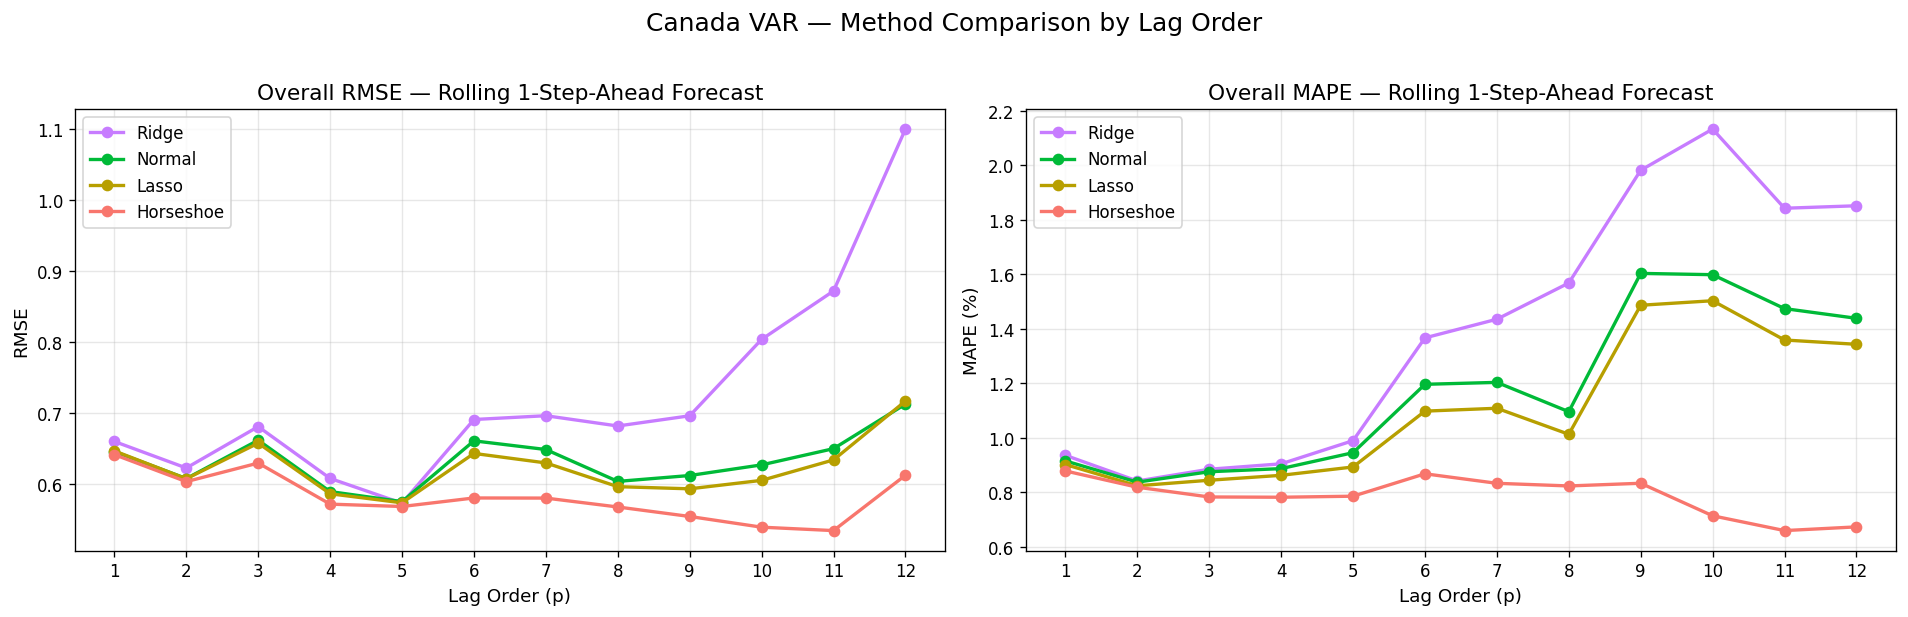

💾 Saved: overall_rmse_mape_vs_lag.png


In [13]:
# ============================================================
# Plot 1 — Overall RMSE / MAPE vs Lag Order
# ============================================================
# Matches R: make_plot(data, "RMSE") + scale_x_continuous(breaks=1:12)
# ============================================================

METHOD_PALETTE = {
    'Ridge': '#C77CFF', 'Normal': '#00BA38',
    'Lasso': '#B79F00', 'Horseshoe': '#F8766D',
}
METHOD_ORDER = ['Ridge', 'Normal', 'Lasso', 'Horseshoe']

df_all = df_results[df_results['variable'] == 'All'].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for idx, metric in enumerate(['RMSE', 'MAPE']):
    ax = axes[idx]
    for method in METHOD_ORDER:
        sub = df_all[df_all['Method'] == method].sort_values('p')
        ax.plot(sub['p'], sub[metric], 'o-', label=method,
                color=METHOD_PALETTE[method], linewidth=2, markersize=6)
    ax.set_xlabel('Lag Order (p)', fontsize=11)
    ylabel = 'RMSE' if metric == 'RMSE' else 'MAPE (%)'
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(f'Overall {metric} — Rolling 1-Step-Ahead Forecast', fontsize=13)
    ax.set_xticks(range(LAG_MIN, LAG_MAX + 1))
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

fig.suptitle('Canada VAR — Method Comparison by Lag Order', fontsize=15, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'overall_rmse_mape_vs_lag.png'),
            dpi=150, bbox_inches='tight')
plt.show()
print('💾 Saved: overall_rmse_mape_vs_lag.png')

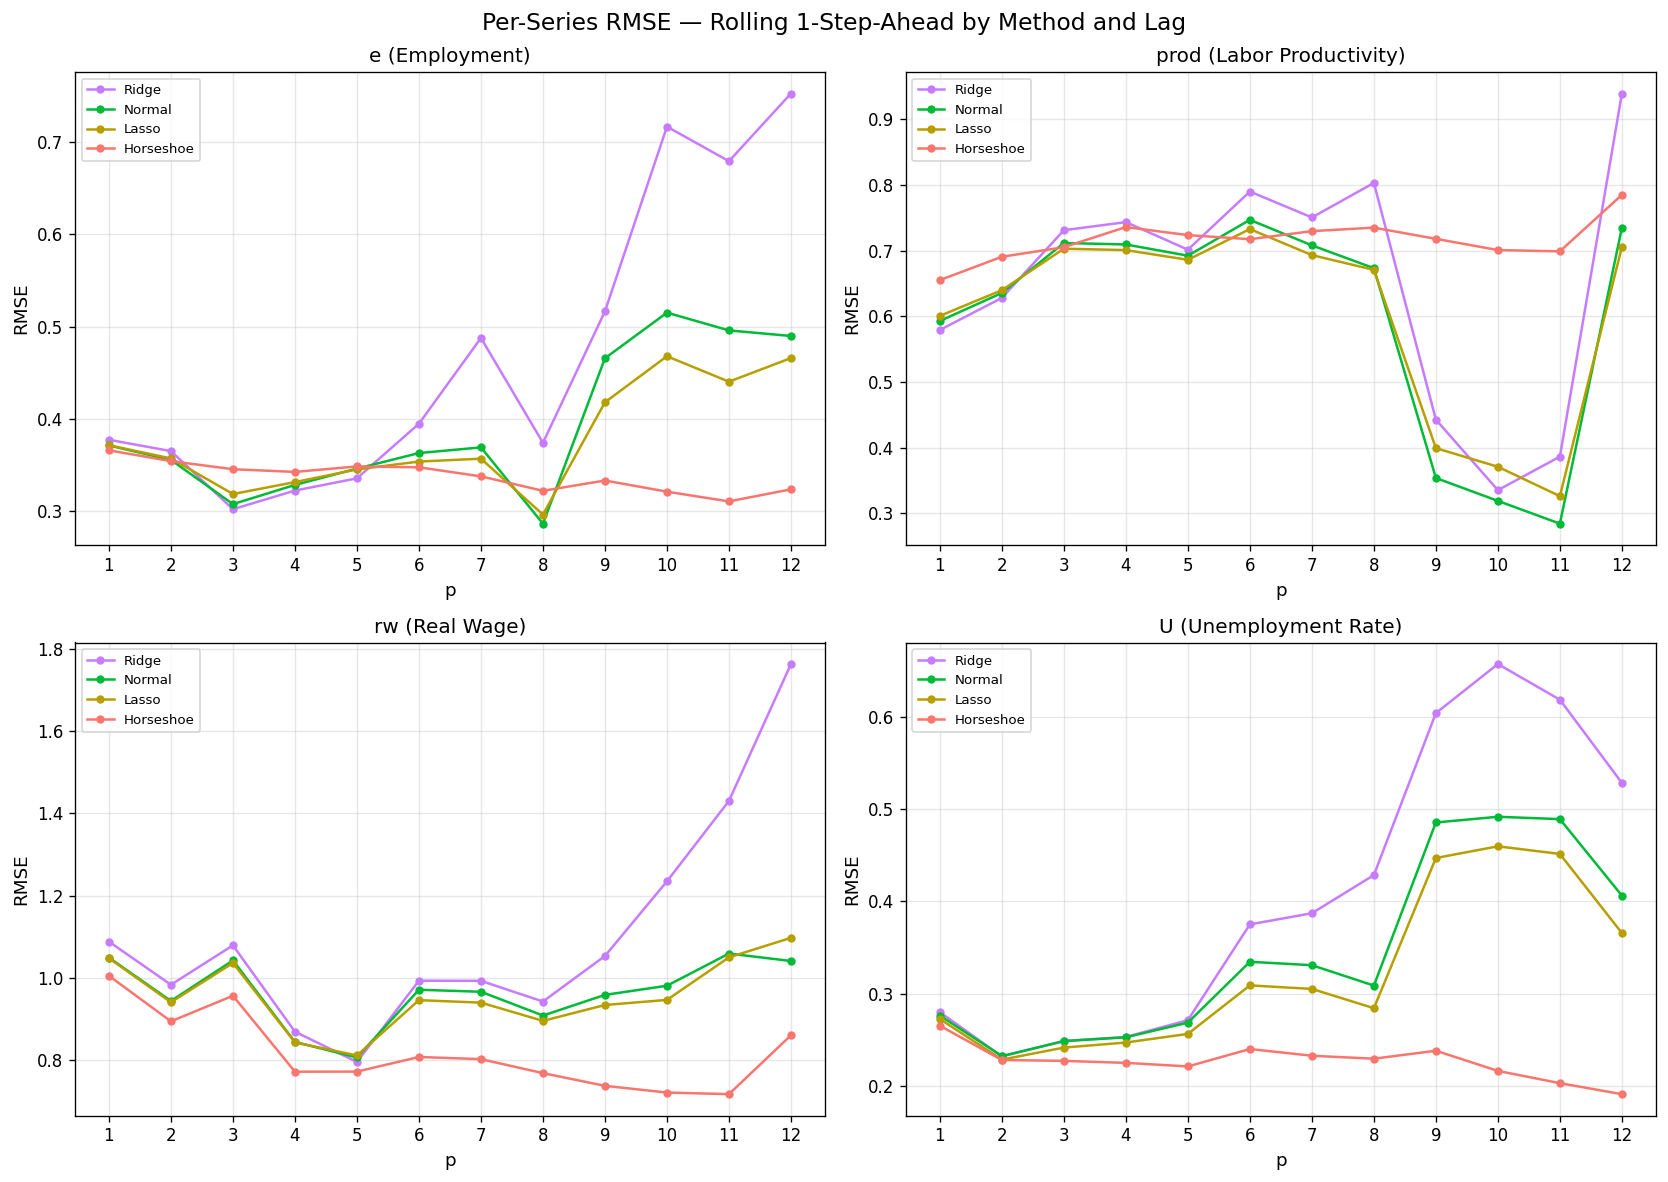

💾 Saved: per_series_rmse_vs_lag.png


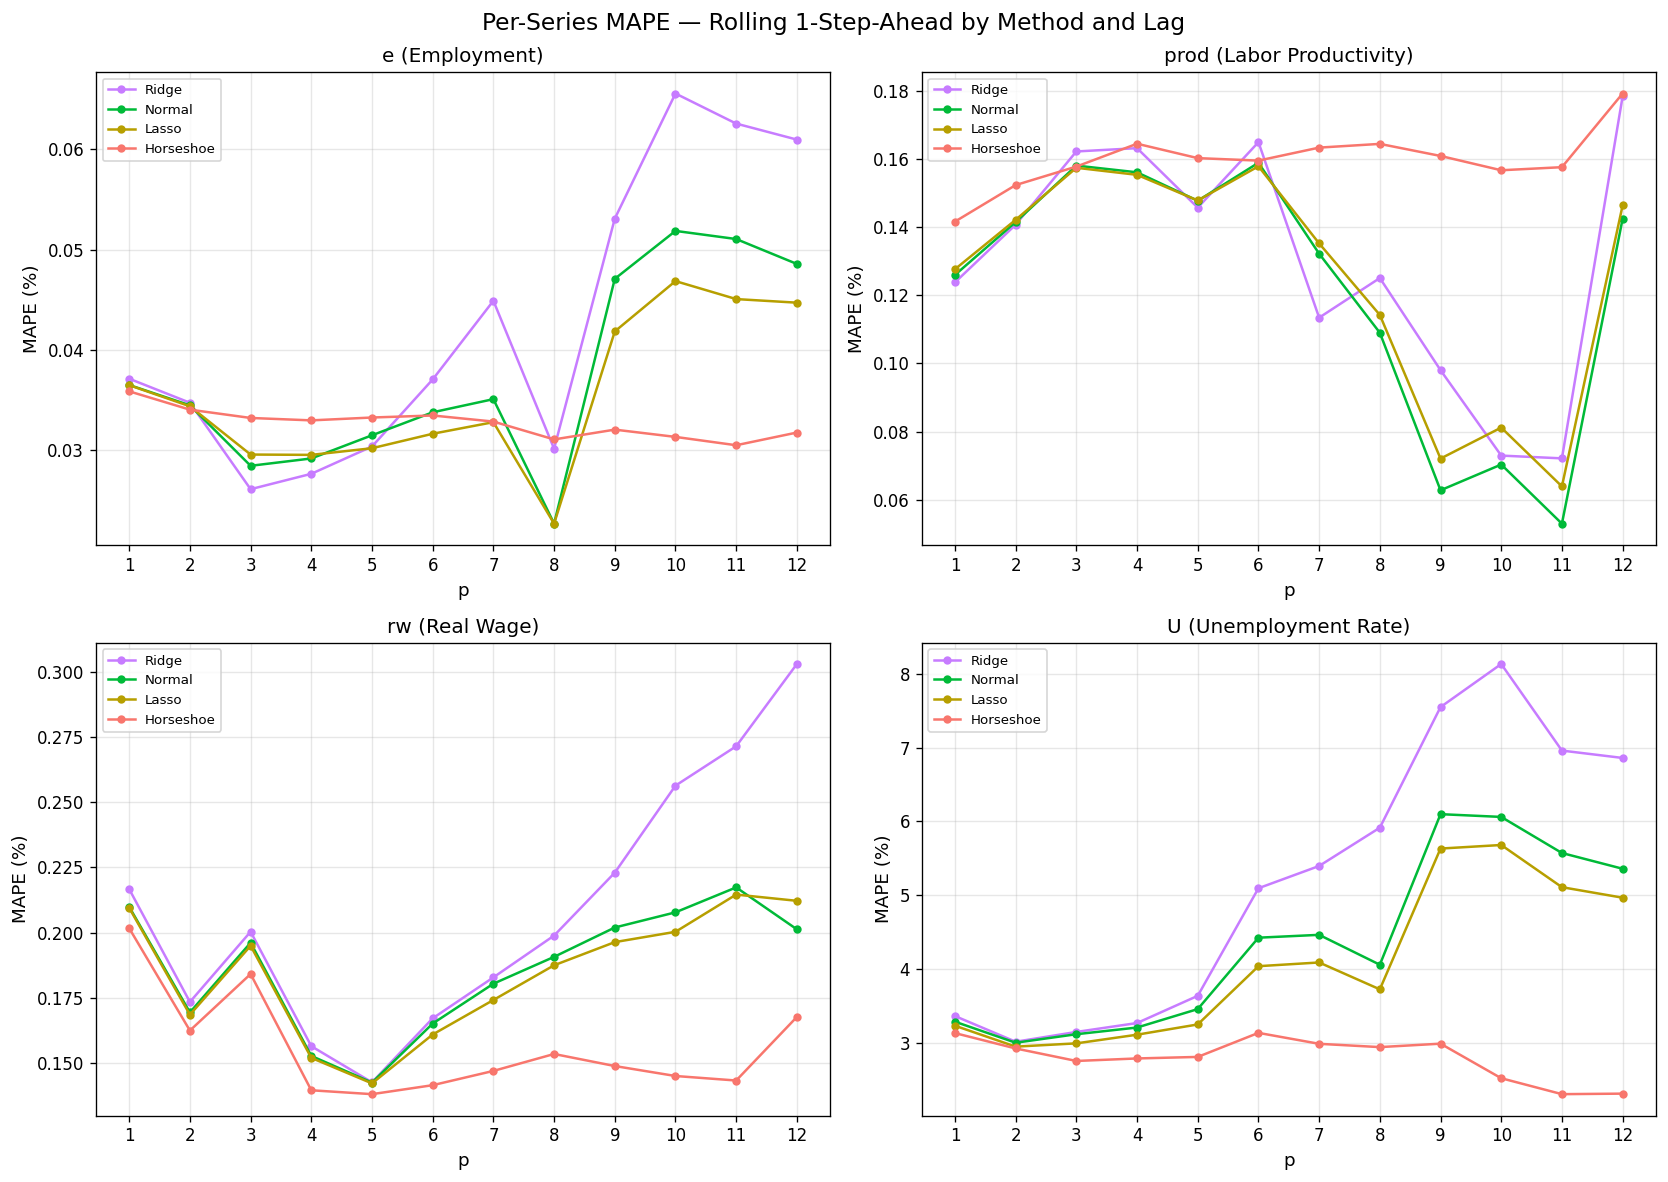

💾 Saved: per_series_mape_vs_lag.png


In [14]:
# ============================================================
# Plot 2 — Per-Series RMSE / MAPE vs Lag Order (2×2 grids)
# ============================================================
# Matches R: facet_wrap(~variable) per-series plots
# ============================================================

for metric in ['RMSE', 'MAPE']:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes_flat = axes.flatten()
    
    for j, col in enumerate(COL_NAMES):
        ax = axes_flat[j]
        df_var = df_results[df_results['variable'] == col].copy()
        
        for method in METHOD_ORDER:
            sub = df_var[df_var['Method'] == method].sort_values('p')
            ax.plot(sub['p'], sub[metric], 'o-', label=method,
                    color=METHOD_PALETTE[method],
                    linewidth=1.5, markersize=4)
        
        ax.set_xlabel('p')
        ylabel = metric if metric == 'RMSE' else f'{metric} (%)'
        ax.set_ylabel(ylabel)
        ax.set_title(f'{col} ({COL_LABELS[col]})', fontsize=12)
        ax.set_xticks(range(LAG_MIN, LAG_MAX + 1))
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)
    
    fig.suptitle(f'Per-Series {metric} — Rolling 1-Step-Ahead by Method and Lag',
                 fontsize=14)
    plt.tight_layout()
    fname = f'per_series_{metric.lower()}_vs_lag.png'
    plt.savefig(os.path.join(OUTPUT_DIR, fname), dpi=150, bbox_inches='tight')
    plt.show()
    print(f'💾 Saved: {fname}')

Best lags used for Actual vs Predicted plots:
  Horseshoe: p=11
  Lasso: p=5
  Normal: p=5
  Ridge: p=5


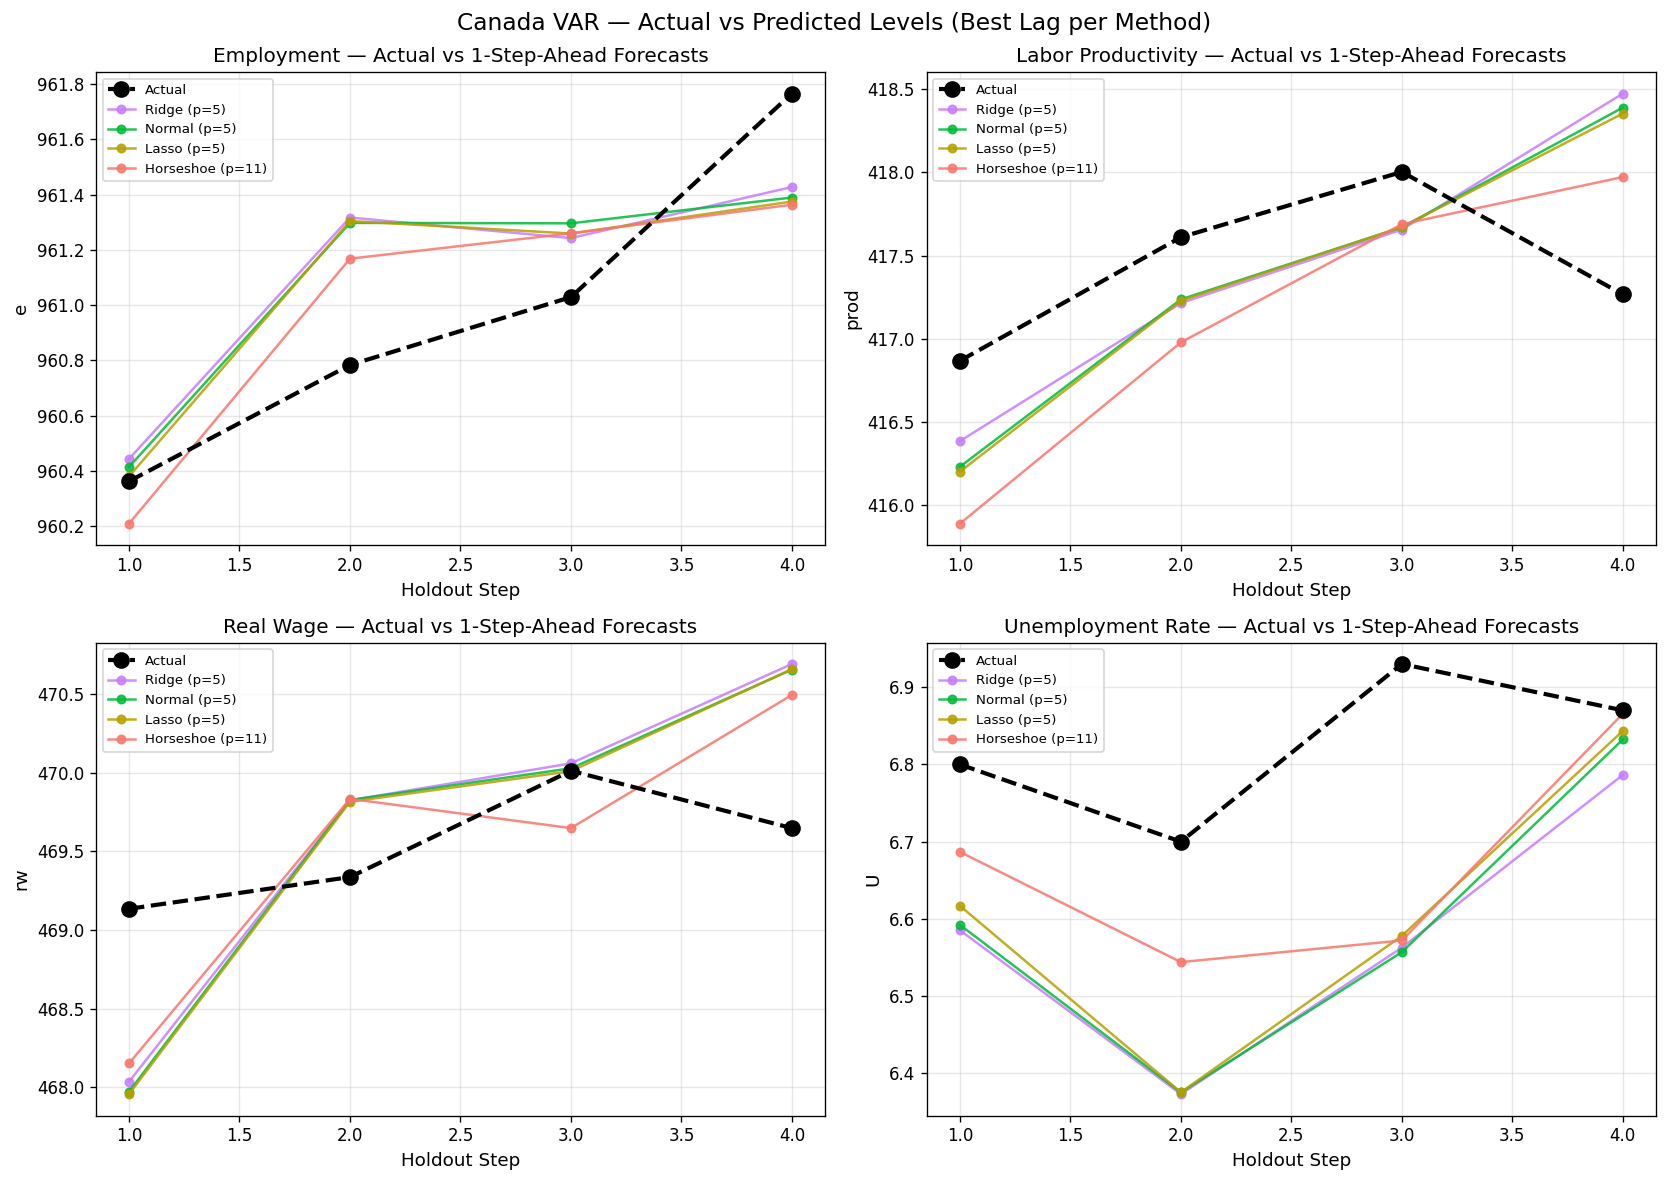

💾 Saved: actual_vs_predicted_best_lag.png


In [15]:
# ============================================================
# Plot 3 — Actual vs Predicted (best lag per method)
# ============================================================
# Uses stored predictions from all_predictions dict
# to avoid re-fitting expensive Bayesian models.
# ============================================================

# Get best lag per method (lowest overall RMSE)
best_p_map = dict(zip(best_per_method['Method'], best_per_method['p'].astype(int)))
print('Best lags used for Actual vs Predicted plots:')
for m, p in best_p_map.items():
    print(f'  {m}: p={p}')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes_flat = axes.flatten()

for j, col in enumerate(COL_NAMES):
    ax = axes_flat[j]
    
    # Actual
    ax.plot(range(1, T_TEST_DIFFS + 1), actual_test_levels[:, j],
            'k--o', linewidth=2.5, markersize=9, label='Actual', zorder=10)
    
    # Each method's prediction at its best lag
    for method_name in METHOD_ORDER:
        best_p = best_p_map[method_name]
        preds = all_predictions[(best_p, method_name)]
        ax.plot(range(1, T_TEST_DIFFS + 1), preds[:, j],
                'o-', label=f'{method_name} (p={best_p})',
                color=METHOD_PALETTE[method_name],
                linewidth=1.5, markersize=5, alpha=0.85)
    
    ax.set_xlabel('Holdout Step')
    ax.set_ylabel(col)
    ax.set_title(f'{COL_LABELS[col]} — Actual vs 1-Step-Ahead Forecasts', fontsize=12)
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

fig.suptitle('Canada VAR — Actual vs Predicted Levels (Best Lag per Method)',
             fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'actual_vs_predicted_best_lag.png'),
            dpi=150, bbox_inches='tight')
plt.show()
print('💾 Saved: actual_vs_predicted_best_lag.png')

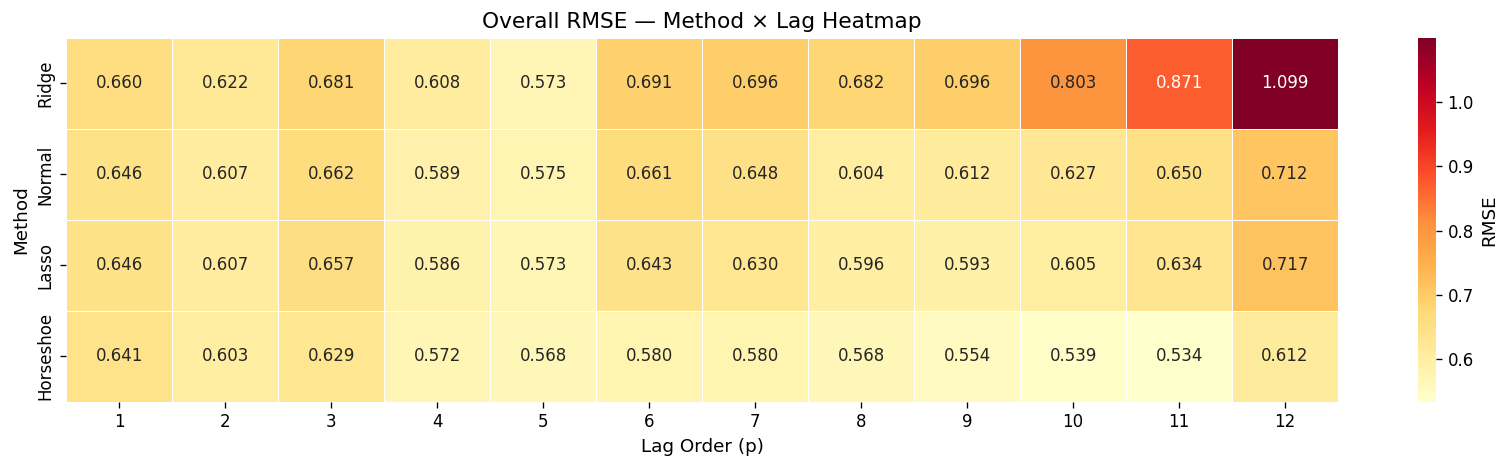

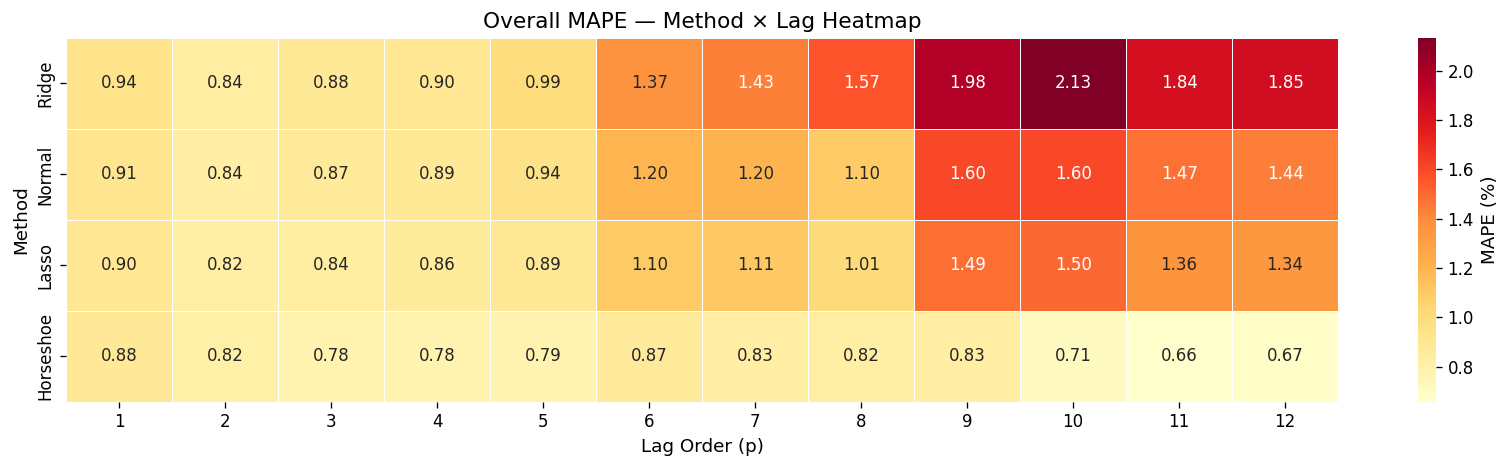

💾 Saved: rmse_heatmap_method_lag.png, mape_heatmap_method_lag.png

  CANADA VAR PIPELINE — COMPLETE
  Lags tested:      1–12
  Models:            Ridge, Normal, Lasso, Horseshoe
  Test horizon:      4 steps (rolling 1-step-ahead)
  Total result rows: 240
  Output directory:  d:\Bayesian Regresion\Lasso\canada_var_results

  Best overall performer:
    Horseshoe at p=11: RMSE=0.5343, MAPE=0.66%


In [16]:
# ============================================================
# Plot 4 — RMSE Heatmap: Method × Lag (diagnostic)
# ============================================================

pivot_rmse = df_all.pivot_table(index='Method', columns='p', values='RMSE')
pivot_rmse = pivot_rmse.loc[METHOD_ORDER]

fig, ax = plt.subplots(figsize=(14, 4))
sns.heatmap(pivot_rmse, annot=True, fmt='.3f', cmap='YlOrRd',
            linewidths=0.5, ax=ax, cbar_kws={'label': 'RMSE'})
ax.set_title('Overall RMSE — Method × Lag Heatmap', fontsize=13)
ax.set_xlabel('Lag Order (p)')
ax.set_ylabel('Method')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'rmse_heatmap_method_lag.png'),
            dpi=150, bbox_inches='tight')
plt.show()

# ── MAPE heatmap ──
pivot_mape = df_all.pivot_table(index='Method', columns='p', values='MAPE')
pivot_mape = pivot_mape.loc[METHOD_ORDER]

fig, ax = plt.subplots(figsize=(14, 4))
sns.heatmap(pivot_mape, annot=True, fmt='.2f', cmap='YlOrRd',
            linewidths=0.5, ax=ax, cbar_kws={'label': 'MAPE (%)'})
ax.set_title('Overall MAPE — Method × Lag Heatmap', fontsize=13)
ax.set_xlabel('Lag Order (p)')
ax.set_ylabel('Method')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'mape_heatmap_method_lag.png'),
            dpi=150, bbox_inches='tight')
plt.show()
print('💾 Saved: rmse_heatmap_method_lag.png, mape_heatmap_method_lag.png')

# ============================================================
# Final Summary
# ============================================================
print('\n' + '='*60)
print('  CANADA VAR PIPELINE — COMPLETE')
print('='*60)
print(f'  Lags tested:      {LAG_MIN}–{LAG_MAX}')
print(f'  Models:            {", ".join(METHOD_ORDER)}')
print(f'  Test horizon:      {T_TEST_DIFFS} steps (rolling 1-step-ahead)')
print(f'  Total result rows: {len(df_results)}')
print(f'  Output directory:  {OUTPUT_DIR}')
print(f'\n  Best overall performer:')
top = best_per_method.sort_values('RMSE').iloc[0]
print(f'    {top["Method"]} at p={int(top["p"])}: '
      f'RMSE={top["RMSE"]:.4f}, MAPE={top["MAPE"]:.2f}%')
print('='*60)